In [29]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from rdkit import Chem 
from rdkit.Chem import AllChem 

# from mordred import Calculator, descriptors

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


# from ngboost import NGBRegressor, NGBClassifier
# from ngboost.distns import Bernoulli

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import accuracy_score, roc_auc_score

from olympus.utils.misc import get_hypervolume, get_pareto, get_pareto_set

In [30]:
def check_if_float(row):
    try:
        float(row['IC50 (nM)'])
        return True
    except:
        return False
    
def mfs(s):
    return Chem.MolFromSmiles(s)

def mts(m):
    return Chem.MolToCXSmiles(m)

def sanitize_smiles(smi):
    m = mfs(smi)
    Chem.SanitizeMol(m)
    return mts(m)

def check_smiles(row):
    try:
        m = mfs(row['smiles'])
        Chem.SanitizeMol(m)
        return True
    except:
        return False
    
    
def convert_dataset(filename):
    df = pd.read_csv(filename, sep='\t')
    df = df[~df['IC50 (nM)'].isnull()]
    map_ = df.apply(check_if_float, axis=1)
    df=df[map_]
    
    cols_to_keep = ['Ligand SMILES', 'IC50 (nM)']
    df = df[cols_to_keep]
    df = df.rename(columns={'Ligand SMILES': 'smiles', 'IC50 (nM)': 'ic50_nm'})
    df = df.astype({'smiles': str, 'ic50_nm': float })
    df['ic50_m'] = df['ic50_nm']*1.e-9
    df['pic50'] = -np.log10(df['ic50_m'])
    
    # drop all bad smiles
    map_ = df.apply(check_smiles, axis=1)
    df= df[map_]
    
    df['smiles'] = [sanitize_smiles(s) for s in df['smiles'].tolist()]
    
    return df

## Load in datasets

In [31]:
# KIT
kdf = convert_dataset(filename='bindingdb/kit.tsv')

k_smi = kdf['smiles'].tolist()
k_mols = [mfs(s) for s in k_smi]
k_X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=2048) for m in k_mols]).astype(np.float32)

print(kdf.shape)
kdf.head()

[07:05:21] Explicit valence for atom # 4 N, 4, is greater than permitted


(866, 4)


,smiles,ic50_nm,ic50_m,pic50
1942,CCc1cc(NC(=O)Nc2ccc(-c3cnc(Nc4cc(N5CCN(CC)CC5)...,0.020,2.000000e-11,10.698970
1943,COc1cc2c(Oc3ccc(NC(=O)NN4C(=O)CSC4c4c(F)cccc4F...,0.029,2.900000e-11,10.537602
1944,COc1cc2nccc(Oc3ccc(NC(=O)C4(C(=O)Nc5ccc(F)cc5)...,0.053,5.300000e-11,10.275724
1945,CCc1cc(NC(=O)Nc2ccc(-c3cnc(Nc4cc(N5CCN(CC)CC5)...,0.120,1.200000e-10,9.920819
1946,CN[C@@H]1CC2OC([C@@H]1OC)n1c3ccccc3c3c4c(c5c6c...,0.180,1.800000e-10,9.744727


In [13]:
# PDGF 
pdf = convert_dataset(filename='bindingdb/pdgf.tsv')

p_smi = pdf['smiles'].tolist()
p_mols = [mfs(s) for s in p_smi]
p_X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=2048) for m in p_mols]).astype(np.float32)

print(pdf.shape)
pdf.head()

(2491, 4)


,smiles,ic50_nm,ic50_m,pic50
50,Cc1ccc(O)cc1Nc1ccnc2c1C(=O)Nc1cc(CNC3CCOC3)ccc1N2,2.97,2.970000e-09,8.527244
51,CCCCNCc1ccc2c(c1)NC(=O)c1c(Nc3cc(O)ccc3C)ccnc1N2,2.98,2.980000e-09,8.525784
52,Cc1ccn(CCCNCc2ccc3c(c2)NC(=O)c2c(Nc4cc(O)ccc4C...,2.98,2.980000e-09,8.525784
53,Cc1ccc(O)cc1Nc1ccnc2c1C(=O)Nc1cc(CNCCCO)ccc1N2,2.99,2.990000e-09,8.524329
54,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(C...,3.00,3.000000e-09,8.522879


In [11]:
# load in the BCR-Abl1 inhibitors 
adf = pd.read_csv('lookup_table.csv')

a_smi = adf['molecule_smi'].tolist()
a_mols = [mfs(s) for s in a_smi]
a_X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=2048) for m in a_mols]).astype(np.float32)


In [10]:
X_comb = np.concatenate((a_X, k_X, p_X))
print(X_comb.shape)
pca = PCA(n_components=2)
X_trans = pca.fit_transform(X_comb)

NameError: name 'k_X' is not defined

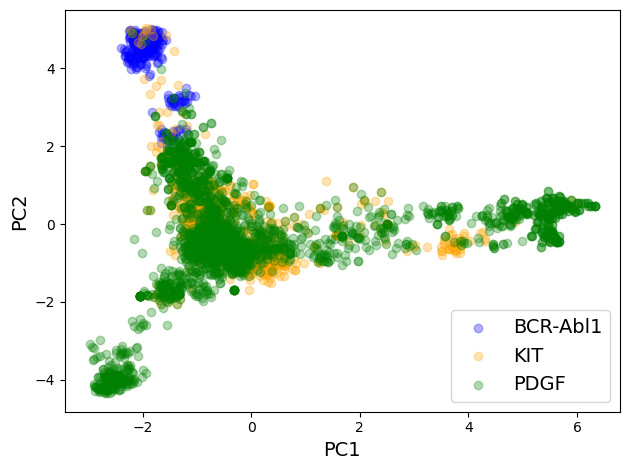

In [16]:
fig, ax = plt.subplots()

ax.scatter(
    X_trans[:a_X.shape[0], 0], X_trans[:a_X.shape[0], 1],
    label='BCR-Abl1', alpha=0.3,c='b'
)
ax.scatter(
    X_trans[a_X.shape[0]:a_X.shape[0]+k_X.shape[0], 0], X_trans[a_X.shape[0]:a_X.shape[0]+k_X.shape[0], 1],
    label='KIT', alpha=0.3, c='orange'
)
ax.scatter(
    X_trans[-p_X.shape[0]:, 0], X_trans[-p_X.shape[0]:, 1],
    label='PDGF', alpha=0.3, c='g',
)




ax.set_xlabel('PC1',fontsize=14)
ax.set_ylabel('PC2',fontsize=14)
ax.legend(loc='lower right', fontsize=14)

plt.tight_layout()

In [9]:
# write chemprop files to disk

# keep_cols = ['smiles', 'pic50']
# pdf[keep_cols].to_csv('chemprop/pdgf_pic50.csv',index=False)
# kdf[keep_cols].to_csv('chemprop/kit_pic50.csv',index=False)

## Analyze Chemprop results

In [71]:
smi = adf['molecule_smi'].tolist()
mols = [mfs(s) for s in smi]
abl_vals = adf['abl1_pIC50'].values
kit_vals = pd.read_csv('chemprop/kit_pic50_abl_preds_reg.csv')['pic50'].values
pdgf_vals = pd.read_csv('chemprop/pdgf_pic50_abl_preds_reg.csv')['pic50'].values

abl_vals.shape, kit_vals.shape, pdgf_vals.shape

((270,), (270,), (270,))

In [72]:
df = pd.DataFrame({'smiles':smi,'mol':mols,'abl':abl_vals,'kit':kit_vals, 'pdgf':pdgf_vals})

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hi

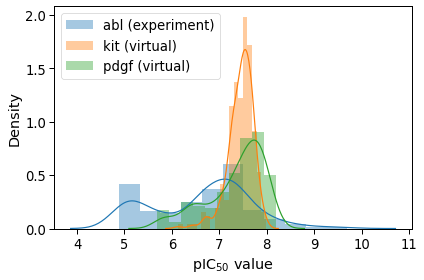

In [76]:
sns.distplot(df['abl'],label='abl (experiment)')
sns.distplot(df['kit'],label='kit (virtual)')
sns.distplot(df['pdgf'],label='pdgf (virtual)')

plt.xlabel(r'pIC$_{50}$ value')
plt.tight_layout()
plt.legend()
plt.savefig('desai_chemprop_pred_dists.png', dpi=300)

In [16]:
# df[
#     (df['abl']>7.5) &\
#     (df['kit']>7.5) &\
#     (df['pdgf']>7.5)
# ]

In [17]:
params = df['smiles'].values.reshape(-1, 1)
vals = -df[['abl', 'kit', 'pdgf']].values
print(vals.shape)
pareto_front, pareto_set = get_pareto_set(params, vals)

(270, 3)


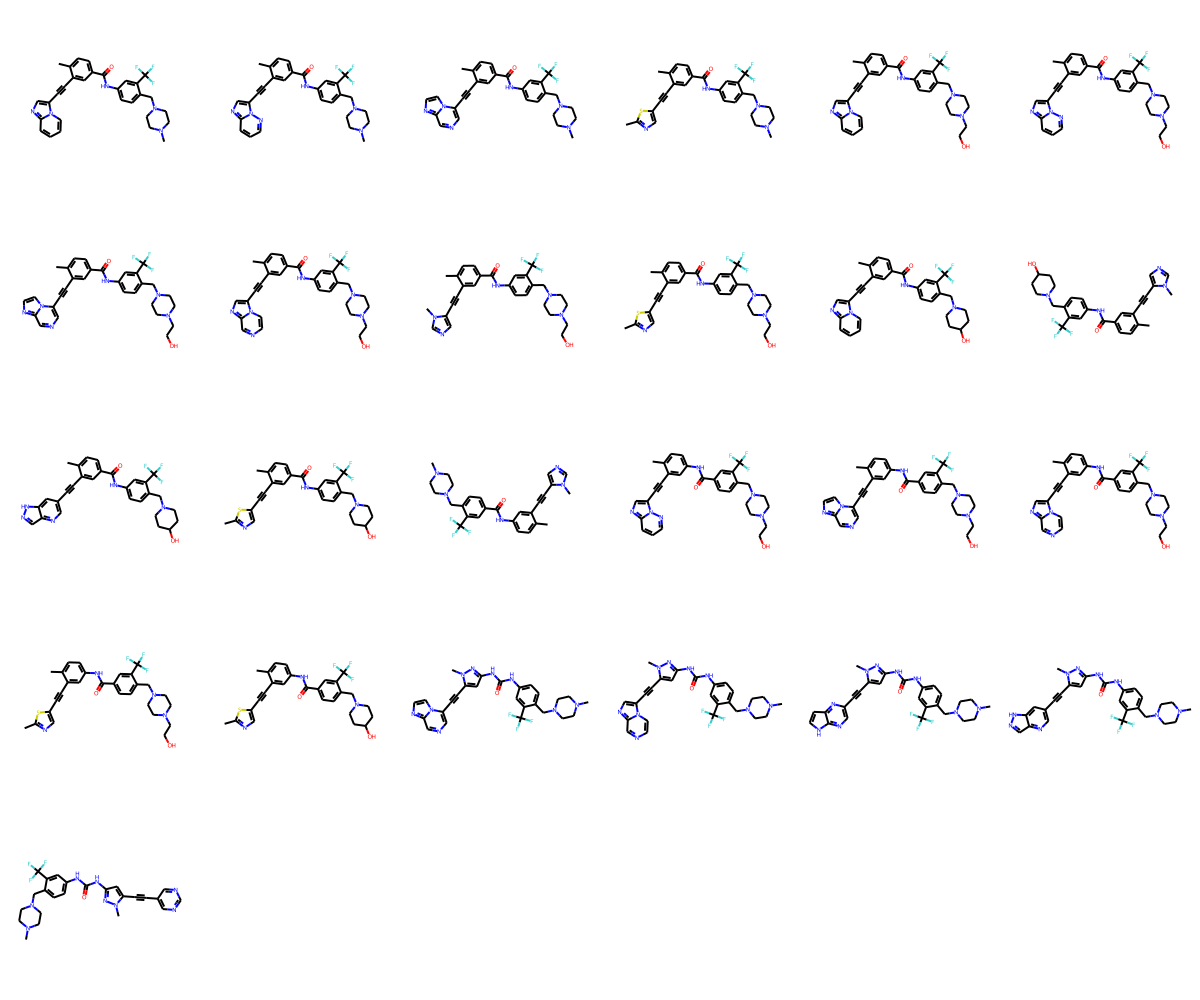

In [84]:
pareto_smi = [p[0] for p in pareto_set]
pareto_mols = [mfs(s) for s in pareto_smi]

AllChem.Draw.MolsToGridImage(pareto_mols, molsPerRow=6)


In [19]:
pareto_front_pos = -pareto_front

In [23]:
df['size']=50

In [27]:
fig = px.scatter_3d(df, x='abl', y='kit', z='pdgf', size='size')

fig.add_trace(go.Mesh3d(
                   x=pareto_front_pos[:,0],
                   y=pareto_front_pos[:,1],
                   z=pareto_front_pos[:,2],
                   opacity=0.2,
                   color='blue',
                  ))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))



fig.update_scenes(
                  xaxis_title_text=r'BCR Abl pIC50',  
                  yaxis_title_text=r'KIT pIC50',  
                  zaxis_title_text=r'PDGF pIC50',
                )

## Chemprop parity plots for KIT and PDGF inhibitors

In [37]:
kit_train = pd.read_csv('chemprop/kit_pic50_checkpoints_reg/fold_0/train_full.csv')['pic50'].values
kit_train_preds = pd.read_csv('chemprop/kit_pic50_train_preds_reg.csv')['pic50'].values

kit_test = pd.read_csv('chemprop/kit_pic50_checkpoints_reg/fold_0/test_full.csv')['pic50'].values
kit_test_preds = pd.read_csv('chemprop/kit_pic50_test_preds_reg.csv')['pic50'].values

print(kit_train.shape, kit_train_preds.shape)
print(kit_test.shape, kit_test_preds.shape)

(1560,) (1560,)
(195,) (195,)


In [39]:
pdgf_train = pd.read_csv('chemprop/pdgf_pic50_checkpoints_reg/fold_0/train_full.csv')['pic50'].values
pdgf_train_preds = pd.read_csv('chemprop/pdgf_pic50_train_preds_reg.csv')['pic50'].values

pdgf_test = pd.read_csv('chemprop/pdgf_pic50_checkpoints_reg/fold_0/test_full.csv')['pic50'].values
pdgf_test_preds = pd.read_csv('chemprop/pdgf_pic50_test_preds_reg.csv')['pic50'].values

print(pdgf_train.shape, pdgf_train_preds.shape)
print(pdgf_test.shape, pdgf_test_preds.shape)

(1992,) (1992,)
(250,) (250,)


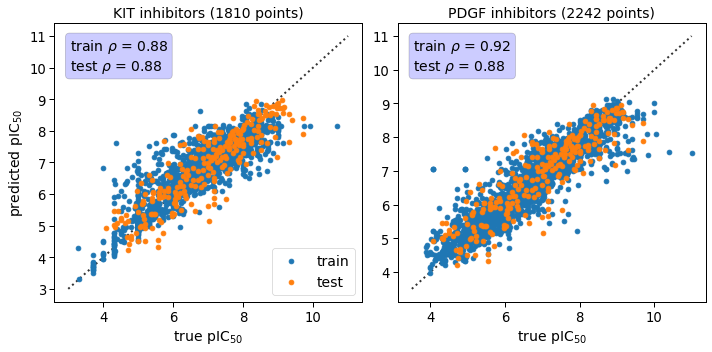

In [70]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

#-----
# kit
#-----
kit_train_p = round(pearsonr(kit_train, kit_train_preds)[0], 2)
kit_test_p = round(pearsonr(kit_test, kit_test_preds)[0], 2)

ax0.scatter(kit_train, kit_train_preds, label='train', zorder=2)
ax0.scatter(kit_test, kit_test_preds, label='test',zorder=3)

ax0.plot([3., 11.], [3., 11.], ls=':', lw=2, alpha=0.8, c='k', zorder=1)

textstr = r'train $\rho$'+f' = {kit_train_p}\n'+r'test $\rho$'+f' = {kit_test_p}'
props = dict(boxstyle='round', facecolor='b', alpha=0.2)
ax0.text(0.05, 0.95, textstr, transform=ax0.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, fontweight='book')

ax0.set_xlabel(r'true pIC$_{50}$',fontsize=14)
ax0.set_ylabel(r'predicted pIC$_{50}$',fontsize=14)

tot_points = kit_train.shape[0]+kit_test.shape[0]
ax0.set_title(f'KIT inhibitors ({tot_points} points)', fontsize=14)

ax0.legend(loc='lower right', fontsize=14)



#-----
# pdgf
#-----
pdgf_train_p = round(pearsonr(pdgf_train, pdgf_train_preds)[0], 2)
pdgf_test_p = round(pearsonr(pdgf_test, pdgf_test_preds)[0], 2)

ax1.scatter(pdgf_train, pdgf_train_preds, label='train', zorder=2)
ax1.scatter(pdgf_test, pdgf_test_preds, label='test',zorder=3)

ax1.plot([3.5, 11.], [3.5, 11.], ls=':', lw=2, alpha=0.8, c='k', zorder=1)

textstr = r'train $\rho$'+f' = {pdgf_train_p}\n'+r'test $\rho$'+f' = {pdgf_test_p}'
props = dict(boxstyle='round', facecolor='b', alpha=0.2)
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, fontweight='book')

ax1.set_xlabel(r'true pIC$_{50}$',fontsize=14)
tot_points = pdgf_train.shape[0]+pdgf_test.shape[0]
ax1.set_title(f'PDGF inhibitors ({tot_points} points)', fontsize=14)


plt.tight_layout()
plt.savefig('chemprop_parity_inhibitors.png', dpi=300)

In [85]:
adf

,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi,synthesis_success,synthesis_success_prob,is_experiment_x,abl1_pIC50,abl1_pIC50_std
0,8-1,22-1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(=N)OC)cn12,COC(=N)c1ccc2ncc(C#Cc3cc(C(=O)Nc4ccc(CN5CCN(C)...,1,0.536046,0,7.390089,7.156328
1,8-1,22-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.045757,1.000000
2,8-1,22-3,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(F)(F)F)cn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0,0.000000,1,7.515735,7.152991
3,8-1,22-4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cccnn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.065502,1.000000
4,8-1,22-5,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cncc2nccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,9.698970,1.000000
...,...,...,...,...,...,...,...,...,...,...
265,19,22-23,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,C#Cc1ccc(N)nc1,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4ccc(N)nc4)n(C)n...,1,0.985571,0,7.493321,7.067724
266,19,22-24,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,C#Cc1ccccc1F,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4ccccc4F)n(C)n3)...,1,0.988859,0,7.109972,7.062334
267,19,22-25,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,C[Si](C)(C)C#Cc1cnc2nccn2c1,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cnc5nccn5c4)n(C...,0,0.000000,1,7.683010,7.071301
268,19,22-26,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,C[Si](C)(C)C#Cc1cncc2nc[nH]c12,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cncc5nc[nH]c45)...,1,1.000000,1,8.522879,1.000000


In [87]:
# add new values to the lookup table
adf['kit_pIC50'] = df['kit']
adf['pdgf_pIC50'] = df['pdgf']

In [89]:
# save new lookup table to disk
adf.to_csv('lookup_table_multiobj.csv', index=False)